In [1]:

######## snakemake preamble start (automatically inserted, do not edit) ########
library(methods)
Snakemake <- setClass(
    "Snakemake",
    slots = c(
        input = "list",
        output = "list",
        params = "list",
        wildcards = "list",
        threads = "numeric",
        log = "list",
        resources = "list",
        config = "list",
        rule = "character",
        bench_iteration = "numeric",
        scriptdir = "character",
        source = "function"
    )
)
snakemake <- Snakemake(
    input = list('data/experiment_ATAC_predictions/traindata_splits_diff_percentages/trimmed_CONTROLS_split_0.8.rds', 'data/20_80_splits_group_by_ind/20_all_samples_normalized_trimmed_CONTROLS.rds', 'data/ATACseq_250kb_bins.txt', "input_train" = 'data/experiment_ATAC_predictions/traindata_splits_diff_percentages/trimmed_CONTROLS_split_0.8.rds', "input_test" = 'data/20_80_splits_group_by_ind/20_all_samples_normalized_trimmed_CONTROLS.rds', "input_atac" = 'data/ATACseq_250kb_bins.txt'),
    output = list('data/experiment_ATAC_predictions/ATAC_predictions/ATAC_pred_lasso_experiment_trimmed_CONTROLS_0.8.rds', 'Trained_models/experiment_models/Lasso_models/lasso_trimmed_CONTROLS_0.8.rds', "output_pred" = 'data/experiment_ATAC_predictions/ATAC_predictions/ATAC_pred_lasso_experiment_trimmed_CONTROLS_0.8.rds', "output_model" = 'Trained_models/experiment_models/Lasso_models/lasso_trimmed_CONTROLS_0.8.rds'),
    params = list(),
    wildcards = list('trimmed_CONTROLS', '0.8', "suffix" = 'trimmed_CONTROLS', "percentage" = '0.8'),
    threads = 5,
    log = list('logs/processed_notebooks/experiments/processed_Lasso_trimmed_CONTROLS_0.8.r.ipynb', "notebook" = 'logs/processed_notebooks/experiments/processed_Lasso_trimmed_CONTROLS_0.8.r.ipynb'),
    resources = list('mem_mb', 'disk_mb', 'tmpdir', 'time', "mem_mb" = 200000, "disk_mb" = 5955, "tmpdir" = '/scratch/56643321', "time" = '48:00:00'),
    config = list(),
    rule = 'ATAC_predictions',
    bench_iteration = as.numeric(NA),
    scriptdir = '/faststorage/project/DELFI1/Workspaces/CarmenAndAnika/20_80_experiments',
    source = function(...){
        wd <- getwd()
        setwd(snakemake@scriptdir)
        source(...)
        setwd(wd)
    }
)
setwd('/faststorage/project/DELFI1/Workspaces/CarmenAndAnika');

######## snakemake preamble end #########


# Lasso regression

In [2]:
library(tidyverse)
library(glmnet)

install.packages('glmnetUtils')
library(glmnetUtils)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-16

Updating HTML index of packages in '.Library'
Making 'packages.html' ...

### Read in data and ATAC values, add ATAC values to the dataframe

In [3]:
#all_samples_controls <- readRDS("../data/experiment_ATAC_predictions/CONTROLS_split_0.05.rds")
all_samples_controls <- readRDS(snakemake@input[["input_train"]])
head(all_samples_controls)

sample,bin,X80,X81,X82,X83,X84,X85,X86,X87,...,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
PGDX16568P,chr10_400,0.0000000000,0.0000000000,0.0000000000,0,0.0000000000,0.0001749781,0,0.000000000,...,0.0001749781,0.0003499563,0.0000000000,0.0001749781,0.0000000000,0.0001749781,0.0000000000,0.0000000000,0.0000000000,0.0001749781
PGDX16568P,chr10_40,0.0000000000,0.0000000000,0.0002340276,0,0.0002340276,0.0000000000,0,0.000000000,...,0.0002340276,0.0002340276,0.0000000000,0.0002340276,0.0000000000,0.0000000000,0.0002340276,0.0000000000,0.0002340276,0.0000000000
PGDX16568P,chr10_4,0.0000000000,0.0002093802,0.0002093802,0,0.0000000000,0.0002093802,0,0.000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0004187605,0.0002093802,0.0000000000,0.0000000000,0.0002093802,0.0000000000,0.0000000000
PGDX16568P,chr10_401,0.0000000000,0.0000000000,0.0000000000,0,0.0000000000,0.0000000000,0,0.000203666,...,0.0004073320,0.0000000000,0.0004073320,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0002036660,0.0000000000,0.0002036660
PGDX16568P,chr10_402,0.0000000000,0.0002337541,0.0000000000,0,0.0000000000,0.0000000000,0,0.000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0002337541,0.0000000000,0.0000000000,0.0004675082,0.0004675082
PGDX16568P,chr10_403,0.0002130379,0.0000000000,0.0000000000,0,0.0000000000,0.0000000000,0,0.000000000,...,0.0004260758,0.0002130379,0.0002130379,0.0002130379,0.0002130379,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000


In [4]:
#ATAC <- read.table("../../../data/ATACseq_250kb_bins.txt", header = FALSE)
ATAC <- read.table(snakemake@input[["input_atac"]], header = FALSE)

colnames(ATAC) <- c("bin", "ATAC_observed")
head(ATAC)

ATAC$ATAC_observed <- as.character(ATAC$ATAC_observed)
ATAC$ATAC_observed <- as.numeric(ATAC$ATAC_observed)
ATAC$bin <- as.character(ATAC$bin)

all_samples_ATAC_controls <- inner_join(all_samples_controls, ATAC, by="bin")

head(all_samples_ATAC_controls)

bin,ATAC_observed
chr1_0,0.05376791
chr10_0,0.29698782
chr10_1,0.40893151
chr10_10,0.30582283
chr10_100,0.59316570
chr10_101,0.47641373


Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message:
“Column `bin` joining factor and character vector, coercing into character vector”

sample,bin,X80,X81,X82,X83,X84,X85,X86,X87,...,X392,X393,X394,X395,X396,X397,X398,X399,X400,ATAC_observed
PGDX16568P,chr10_400,0.0000000000,0.0000000000,0.0000000000,0,0.0000000000,0.0001749781,0,0.000000000,...,0.0003499563,0.0000000000,0.0001749781,0.0000000000,0.0001749781,0.0000000000,0.0000000000,0.0000000000,0.0001749781,0.5866651
PGDX16568P,chr10_40,0.0000000000,0.0000000000,0.0002340276,0,0.0002340276,0.0000000000,0,0.000000000,...,0.0002340276,0.0000000000,0.0002340276,0.0000000000,0.0000000000,0.0002340276,0.0000000000,0.0002340276,0.0000000000,0.1996134
PGDX16568P,chr10_4,0.0000000000,0.0002093802,0.0002093802,0,0.0000000000,0.0002093802,0,0.000000000,...,0.0000000000,0.0000000000,0.0004187605,0.0002093802,0.0000000000,0.0000000000,0.0002093802,0.0000000000,0.0000000000,0.5968816
PGDX16568P,chr10_401,0.0000000000,0.0000000000,0.0000000000,0,0.0000000000,0.0000000000,0,0.000203666,...,0.0000000000,0.0004073320,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0002036660,0.0000000000,0.0002036660,0.2905764
PGDX16568P,chr10_402,0.0000000000,0.0002337541,0.0000000000,0,0.0000000000,0.0000000000,0,0.000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0002337541,0.0000000000,0.0000000000,0.0004675082,0.0004675082,0.2319729
PGDX16568P,chr10_403,0.0002130379,0.0000000000,0.0000000000,0,0.0000000000,0.0000000000,0,0.000000000,...,0.0002130379,0.0002130379,0.0002130379,0.0002130379,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.2262170


In [5]:
ATAC_val <- all_samples_ATAC_controls %>% select(ATAC_observed)
controls_predictions <- all_samples_ATAC_controls %>% select(sample, bin)
all_samples_ATAC_controls = all_samples_ATAC_controls %>% select(-c(ATAC_observed, sample, bin))

head(all_samples_ATAC_controls)
head(ATAC_val)

X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,...,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
0.0000000000,0.0000000000,0.0000000000,0,0.0000000000,0.0001749781,0,0.000000000,0.0001749781,0.0000000000,...,0.0001749781,0.0003499563,0.0000000000,0.0001749781,0.0000000000,0.0001749781,0.0000000000,0.0000000000,0.0000000000,0.0001749781
0.0000000000,0.0000000000,0.0002340276,0,0.0002340276,0.0000000000,0,0.000000000,0.0000000000,0.0000000000,...,0.0002340276,0.0002340276,0.0000000000,0.0002340276,0.0000000000,0.0000000000,0.0002340276,0.0000000000,0.0002340276,0.0000000000
0.0000000000,0.0002093802,0.0002093802,0,0.0000000000,0.0002093802,0,0.000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0004187605,0.0002093802,0.0000000000,0.0000000000,0.0002093802,0.0000000000,0.0000000000
0.0000000000,0.0000000000,0.0000000000,0,0.0000000000,0.0000000000,0,0.000203666,0.0000000000,0.0000000000,...,0.0004073320,0.0000000000,0.0004073320,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0002036660,0.0000000000,0.0002036660
0.0000000000,0.0002337541,0.0000000000,0,0.0000000000,0.0000000000,0,0.000000000,0.0000000000,0.0002337541,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0002337541,0.0000000000,0.0000000000,0.0004675082,0.0004675082
0.0002130379,0.0000000000,0.0000000000,0,0.0000000000,0.0000000000,0,0.000000000,0.0000000000,0.0000000000,...,0.0004260758,0.0002130379,0.0002130379,0.0002130379,0.0002130379,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000


ATAC_observed
0.5866651
0.1996134
0.5968816
0.2905764
0.2319729
0.2262170


# Lasso regression

## Cross validation to find the best lambda and alpha

In [6]:
get_cvm <- function(model) {
   index <- match(model$lambda.min, model$lambda)
  model$cvm[index]
}

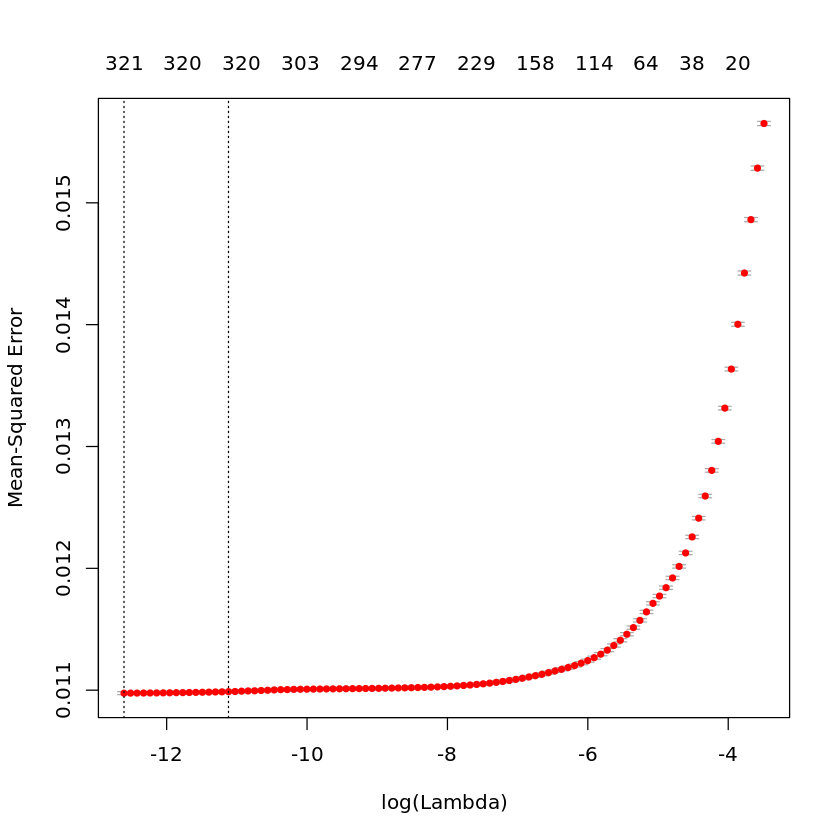

In [7]:
set.seed(0)

y <- ATAC_val %>% as.matrix()
X <- all_samples_ATAC_controls %>% as.matrix()

######### finding the best alpha #########
set.seed(0)
lasso_cva <- glmnetUtils::cva.glmnet(X, y, nfolds = 10)
enet_performance <- data.frame(alpha = lasso_cva$alpha)
models <- lasso_cva$modlist
enet_performance$cvm <- vapply(models, get_cvm, numeric(1))

minix <- which.min(enet_performance$cvm)
best_alpha <- lasso_cva$alpha[minix]
###########################################

######### finding the best lambda #########
set.seed(0)
lasso_cv <- glmnet::cv.glmnet(X, y, alpha = best_alpha,
                      standardize = TRUE, nfolds = 10)

plot(lasso_cv)
###########################################

In [8]:
(lambda_cv <- lasso_cv$lambda.min)

[1] 3.346336e-06

## Fit the model on all traindata controls

In [9]:
y <- ATAC_val %>% as.matrix()
X <- all_samples_ATAC_controls %>% as.matrix()

fit       <- glmnet::glmnet(X, y, alpha = best_alpha, lambda = lambda_cv, standardize = TRUE)
# saving the model
saveRDS(fit, snakemake@output[["output_model"]])


## Predict on normalized 20% of controls using the model (fitted on train controls) and save the predictions to file

In [10]:
#filename = "../../../data/all_samples_normalized_CASES.csv"
#test_data = readRDS("../../data/20_80_splits/20_all_samples_normalized_CONTROLS.rds")

test_data = readRDS(snakemake@input[["input_test"]])

In [11]:
head(test_data)

sample,bin,X80,X81,X82,X83,X84,X85,X86,X87,...,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
PGDX16571P,chr10_400,0.0002120441,0.0000000000,0.0000000000,0,0,0,0,0,...,0.0002120441,0.0002120441,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0,0.0000000000
PGDX16571P,chr10_40,0.0000000000,0.0000000000,0.0002698327,0,0,0,0,0,...,0.0000000000,0.0000000000,0.0000000000,0.0002698327,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0,0.0000000000
PGDX16571P,chr10_4,0.0000000000,0.0000000000,0.0000000000,0,0,0,0,0,...,0.0002366304,0.0000000000,0.0002366304,0.0000000000,0.0002366304,0.0000000000,0.0002366304,0.0002366304,0,0.0000000000
PGDX16571P,chr10_401,0.0000000000,0.0004844961,0.0000000000,0,0,0,0,0,...,0.0000000000,0.0000000000,0.0000000000,0.0002422481,0.0000000000,0.0004844961,0.0000000000,0.0000000000,0,0.0002422481
PGDX16571P,chr10_402,0.0000000000,0.0000000000,0.0000000000,0,0,0,0,0,...,0.0000000000,0.0002767783,0.0000000000,0.0002767783,0.0002767783,0.0005535566,0.0000000000,0.0000000000,0,0.0000000000
PGDX16571P,chr10_403,0.0000000000,0.0000000000,0.0000000000,0,0,0,0,0,...,0.0000000000,0.0005182690,0.0000000000,0.0000000000,0.0000000000,0.0005182690,0.0000000000,0.0000000000,0,0.0000000000


In [12]:
test_data_samples_bin_rm <- test_data %>% select(-c("sample", "bin")) %>% as.matrix()
tmp <- as.vector(predict(fit, s=lambda_cv, test_data_samples_bin_rm))

In [13]:
pred_tibble <- tibble(sample = test_data$sample, bin = test_data$bin)
pred_tibble <- inner_join(pred_tibble, ATAC, by="bin")
pred_tibble <- pred_tibble %>% mutate(ATAC_predicted = tmp)

Warning message:
“Column `bin` joining factor and character vector, coercing into character vector”

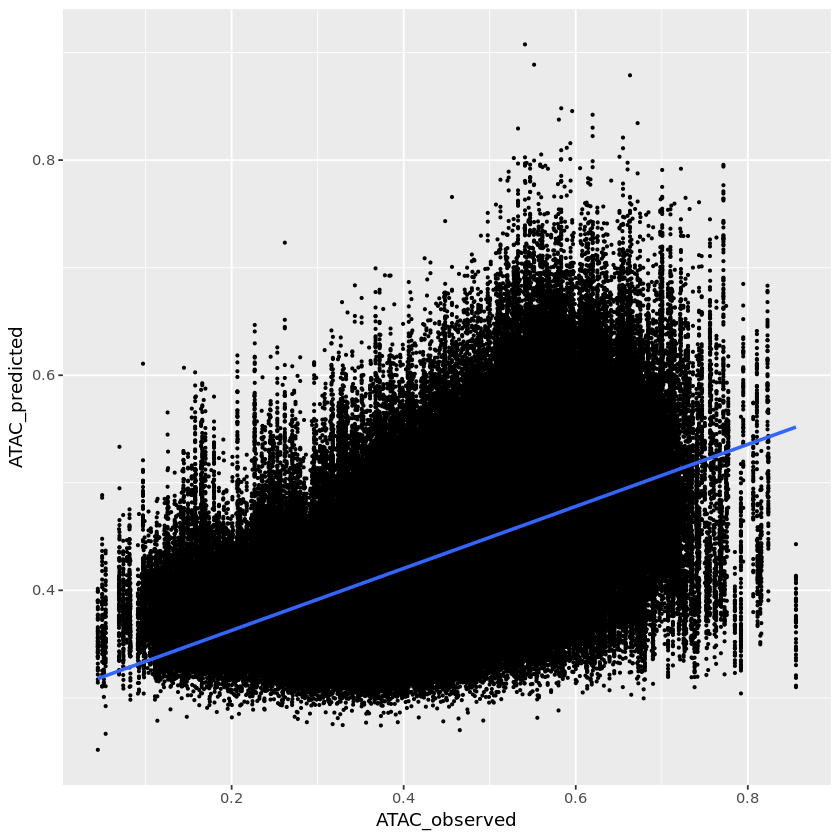

In [14]:
ggplot(pred_tibble, aes(x = ATAC_observed, y = ATAC_predicted)) + 
    geom_point(size = 0.5) + 
    geom_smooth(method = "lm", formula = y~x)

In [15]:
cor(pred_tibble$ATAC_observed, pred_tibble$ATAC_predicted)

[1] 0.5404296

In [16]:
ae    <- abs(pred_tibble$ATAC_observed - pred_tibble$ATAC_predicted)
(mae   <- mean(ae))

[1] 0.08186512

In [17]:
se    <- (pred_tibble$ATAC_observed - pred_tibble$ATAC_predicted)^2
mse   <- mean(se)
(rmse <- sqrt(mse))

[1] 0.105297

In [18]:
saveRDS(pred_tibble, file = snakemake@output[["output_pred"]])